# Analyse results
Here we will analyze the first results of the experiments

## Data Loading
We load the data and merge the  different files. Furthermore, we rename the variables for ansatz, optimizer and featuremap to make the more user friendly.


In [101]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 

from scipy.stats import friedmanchisquare,  wilcoxon, kruskal, mannwhitneyu

sns.set(font_scale=1.25)
sns.set(style='white', palette=None)

In [102]:
declare = True
res = []

for noise, noise_string in zip(['none', 'ibm_perth'], ['_', 'ibm_perth']):
    for init in ['uniform', 'beta', 'normal']:
        res_current = []
        for optimizer in ['cobyla', 'spsa', 'neldermead']:
            for preprocessing in ['pca', 'lda']:
                res_current.append(pd.read_csv('../reports/results/glass_identification_' + noise_string + '_' + optimizer + '_' + preprocessing + "_" + init + "_" + 'results.csv', index_col=0))
        res_current = pd.concat(res_current)
        res_current['noise'] = noise
        res_current['initialization'] = init
        res.append(res_current)
res = pd.concat(res)
res.head()

,accuracy,f1,time,ansatz,optimizer,featuremap,entanglement,entanglement_featuremap,iterations,preprocessing,noise,initialization
index,,,,,,,,,,,,
0,0.488372,0.488421,426.369733,<function get_efficientsu2 at 0x7f2b7826f9d0>,<function get_cobyla at 0x7f2b47c04040>,<function get_zfeaturemap at 0x7f2b7ee4a1f0>,full,NaN,202,pca,none,uniform
1,0.441860,0.412520,449.528344,<function get_efficientsu2 at 0x7f2b7826f9d0>,<function get_cobyla at 0x7f2b47c04040>,<function get_zfeaturemap at 0x7f2b7ee4a1f0>,linear,NaN,247,pca,none,uniform
2,0.302326,0.258619,428.005836,<function get_efficientsu2 at 0x7f2b7826f9d0>,<function get_cobyla at 0x7f2b47c04040>,<function get_zfeaturemap at 0x7f2b7ee4a1f0>,circular,NaN,228,pca,none,uniform
3,0.418605,0.395349,763.010007,<function get_efficientsu2 at 0x7f2b7826f9d0>,<function get_cobyla at 0x7f2b47c04040>,<function get_zfeaturemap at 0x7f2b7ee4a1f0>,sca,NaN,405,pca,none,uniform
4,0.209302,0.225413,812.025835,<function get_efficientsu2 at 0x7f2b7826f9d0>,<function get_cobyla at 0x7f2b47c04040>,<function get_zzfeaturemap at 0x7f2b7ee4a280>,full,full,249,pca,none,uniform


In [103]:
# if ansatz contains 'efficientsu2' replace with 'efficient_su2'
res['ansatz'] = res['ansatz'].apply(lambda x: 'efficient_su2' if 'efficientsu2' in x else x)
# if ansatz = 'paulitwodesign' replace with 'pauli_two_design'
res['ansatz'] = res['ansatz'].apply(lambda x: 'pauli_two_design' if 'paulitwodesign' in x else x)
# if ansatz = 'realamplitudes' replace with 'real_amplitudes'
res['ansatz'] = res['ansatz'].apply(lambda x: 'real_amplitudes' if 'realamplitudes' in x else x)
# if ansatz = 'twolocal' replace with 'two_local'
res['ansatz'] = res['ansatz'].apply(lambda x: 'two_local' if 'twolocal' in x else x)
# otherwise drop
res = res[res['ansatz'].isin(['efficient_su2', 'pauli_two_design', 'real_amplitudes', 'two_local'])]

In [104]:
# if optimizer contains 'cobyla' replace with 'cobyla'
res['optimizer'] = res['optimizer'].apply(lambda x: 'cobyla' if 'cobyla' in x else x)
# if optimizer = 'lbfgsb' replace with 'l_bfgs_b'
res['optimizer'] = res['optimizer'].apply(lambda x: 'spsa' if 'spsa' in x else x)
# if optimizer = 'neldermead' replace with 'nelder_mead'
res['optimizer'] = res['optimizer'].apply(lambda x: 'nelder_mead' if 'neldermead' in x else x)

In [105]:
# if feature_map contains 'pauli' replace with 'pauli'
res['featuremap'] = res['featuremap'].apply(lambda x: 'pauli' if 'pauli' in x else x)
# if feature_map = 'ZZFeatureMap' replace with 'zz'
res['featuremap'] = res['featuremap'].apply(lambda x: 'zz' if 'zzfeaturemap' in x else x)
# if feature_map = 'ZFeatureMap' replace with 'z'
res['featuremap'] = res['featuremap'].apply(lambda x: 'z' if 'zfeaturemap' in x else x)

In [106]:
index = ['ansatz', 'featuremap', 'entanglement', 'entanglement_featuremap', 'preprocessing', 'optimizer', 'initialization']

best_configs = res[res['accuracy'] > max(res['accuracy']) - 0.1]
worst_configs = res[res['accuracy'] < min(res['accuracy']) + 0.1]

In [107]:
# get absolute difference between noise and no noise
noise = res[res['noise'] == 'ibm_perth'].set_index(index).sort_index()
no_noise = res[res['noise'] == 'none'].set_index(index).sort_index()
diff = np.abs(noise['accuracy'] - no_noise['accuracy'])

In [108]:
most_similar = diff[diff < min(diff) + 0.05].reset_index()
least_similar = diff[diff > max(diff) - 0.05].reset_index()

In [109]:
print("Mean difference between noise and no noise: ", diff.mean())
print("Standard deviation of difference between noise and no noise: ", diff.std())

Mean difference between noise and no noise:  0.07727328657561217
Standard deviation of difference between noise and no noise:  0.060613331632506914


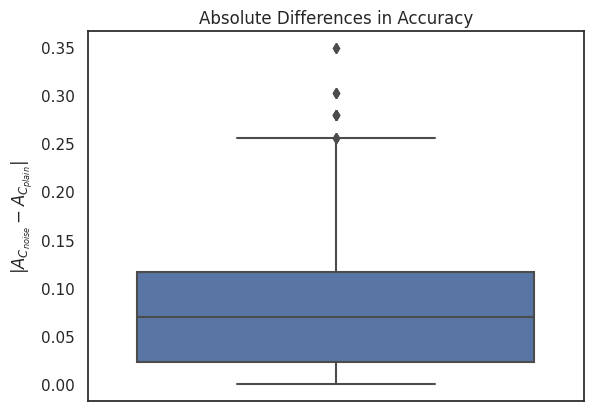

In [110]:
sns.boxplot(diff, palette='deep')
# name x tick of box plot
plt.xticks([0], [''])
plt.ylabel(r'$|{A}_{C_{noise}} - {A}_{C_{plain}}|$')
plt.title('Absolute Differences in Accuracy')
plt.savefig("../reports/figures/covtype_abs_diff.png")
plt.show()

In [111]:
print("Min difference between noise and no noise: ", diff.min())
print("Max difference between noise and no noise: ", diff.max())

Min difference between noise and no noise:  0.0
Max difference between noise and no noise:  0.34883720930232565


In [112]:
print("Results with noise significantly better ", wilcoxon(noise['accuracy'], no_noise['accuracy'], alternative='greater').pvalue < 0.05)

Results with noise significantly better  True


## Optimizer
We first consider the optimizer.
* All in all, NelderMead by far the worst
* COBYLA and Nelder-Mead with an without noise significantly different
* Interestingly, SPSA make up the biggest part of the least similar configurations

In [113]:
res.groupby(['optimizer', 'noise']).agg({"accuracy":[np.mean, np.median, np.std], "f1":[np.mean, np.median, np.std]})

accuracy                            f1             
                           mean    median       std      mean    median   
optimizer   noise                                                         
cobyla      ibm_perth  0.279670  0.279070  0.081652  0.268345  0.268904  \
            none       0.279347  0.255814  0.106778  0.276130  0.262598   
nelder_mead ibm_perth  0.231082  0.232558  0.075503  0.233628  0.232558   
            none       0.209487  0.209302  0.075289  0.217297  0.220682   
spsa        ibm_perth  0.282900  0.279070  0.082781  0.268926  0.264955   
            none       0.294850  0.279070  0.117817  0.291681  0.287278   

                                 
                            std  
optimizer   noise                
cobyla      ibm_perth  0.070100  
            none       0.095021  
nelder_mead ibm_perth  0.070194  
            none       0.074287  
spsa        ibm_perth  0.073258  
            none       0.102842

In [114]:
c = res[res['optimizer'] == 'cobyla'].set_index(index).sort_index()
n = res[res['optimizer'] == 'nelder_mead'].set_index(index).sort_index()
s = res[res['optimizer'] == 'spsa'].set_index(index).sort_index()

In [115]:
# Wilcoxon
print("Wilcoxon: Cobyla without noise significantly different:", wilcoxon(c.loc[c['noise'] == 'none','accuracy'].sort_index(), c.loc[c['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
print("Wilcoxon: SPSA without noise significantly better",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'].sort_index(), s.loc[s['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Nelder Mead without noise significantly worse:",  wilcoxon(n.loc[n['noise'] == 'none','accuracy'].sort_index(), n.loc[n['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)

Wilcoxon: Cobyla without noise significantly different: False
Wilcoxon: SPSA without noise significantly better True
Wilcoxon: Nelder Mead without noise significantly worse: True


In [116]:
# sort by performance
res = res.sort_values(by=['f1', 'accuracy'], ascending=False).reset_index(drop=True)
res.head()

,accuracy,f1,time,ansatz,optimizer,featuremap,entanglement,entanglement_featuremap,iterations,preprocessing,noise,initialization
0,0.604651,0.571749,608.743997,efficient_su2,cobyla,zz,linear,sca,280,pca,none,beta
1,0.627907,0.561586,470.346298,efficient_su2,cobyla,z,sca,NaN,349,lda,none,beta
2,0.558140,0.546770,641.711052,two_local,spsa,zz,linear,circular,351,pca,none,beta
3,0.581395,0.538715,302.349984,efficient_su2,cobyla,z,circular,NaN,223,lda,none,beta
4,0.534884,0.535480,663.465386,real_amplitudes,spsa,zz,sca,circular,351,pca,none,beta


In [117]:
most_similar.value_counts(['optimizer'])/res.value_counts(['optimizer'])

optimizer  
cobyla         0.224206
nelder_mead    0.240079
spsa           0.213294
Name: count, dtype: float64

In [118]:
least_similar.value_counts(['optimizer'])/res.value_counts(['optimizer'])

optimizer  
cobyla         0.000992
nelder_mead    0.002976
spsa           0.000992
Name: count, dtype: float64

## Ansatz
We now consider the ansatz parameter alone.
* All ansatzes, except PauliTwoDesign, perform signficantly different with and without noise
* None of the Pauli configurations are among the least similar ones
* Other than that, comparable ratios in the most similar ones

In [119]:
res.groupby(['ansatz', 'noise']).agg({"accuracy":[np.mean, np.std], "f1":[np.mean, np.std]})

accuracy                  f1          
                                mean       std      mean       std
ansatz           noise                                            
efficient_su2    ibm_perth  0.262059  0.079327  0.256318  0.069216
                 none       0.262651  0.113498  0.262765  0.100566
pauli_two_design ibm_perth  0.258613  0.089349  0.251232  0.079262
                 none       0.245047  0.105328  0.248238  0.094982
real_amplitudes  ibm_perth  0.268088  0.086202  0.258145  0.076074
                 none       0.261789  0.104799  0.262671  0.095443
two_local        ibm_perth  0.264901  0.083259  0.257688  0.072402
                 none       0.262877  0.106812  0.262772  0.095516

In [120]:
e = res[res['ansatz'] == 'efficient_su2'].set_index(index)
p = res[res['ansatz'] == 'pauli_two_design'].set_index(index)
r = res[res['ansatz'] == 'real_amplitudes'].set_index(index)
t = res[res['ansatz'] == 'two_local'].set_index(index)

In [121]:
# Wilcoxon
print("Wilcoxon: EfficientSU2 with and without noise significantly different:", wilcoxon(e.loc[e['noise'] == 'none','accuracy'], e.loc[e['noise'] != 'none', 'accuracy']).pvalue < 0.05)
print("Wilcoxon: PauliTwoDesign without noise significantly worse:",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'], s.loc[s['noise'] != 'none', 'accuracy'], alternative='less').pvalue < 0.05)
print("Wilcoxon: RealAmplitudes without noise significantly worse:",  wilcoxon(r.loc[r['noise'] == 'none','accuracy'], r.loc[r['noise'] != 'none', 'accuracy'], alternative='less').pvalue < 0.05)
print("Wilcoxon: TwoLocal without noise significantly different:",  wilcoxon(t.loc[t['noise'] == 'none','accuracy'], t.loc[t['noise'] != 'none', 'accuracy']).pvalue < 0.05)

Wilcoxon: EfficientSU2 with and without noise significantly different: False
Wilcoxon: PauliTwoDesign without noise significantly worse: False
Wilcoxon: RealAmplitudes without noise significantly worse: True
Wilcoxon: TwoLocal without noise significantly different: False


In [122]:
most_similar.value_counts(['ansatz'])/res.value_counts(['ansatz'])

ansatz          
efficient_su2       0.206019
pauli_two_design    0.236111
real_amplitudes     0.243056
two_local           0.225926
Name: count, dtype: float64

In [123]:
least_similar.value_counts(['ansatz'])/res.value_counts(['ansatz'])

ansatz          
efficient_su2       0.001157
pauli_two_design         NaN
real_amplitudes     0.003472
two_local           0.000926
Name: count, dtype: float64

## Ansatz Entanglement
* Circular, full and linear entanglement with and without noise are significantly different
* Does not apply for pairwise and sca
* Still, no full configurations are among the least similar ones
* Pairwise has the biggest ratio among the least similar configs

In [124]:
res.groupby(['entanglement', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                            f1             
                            mean    median       std      mean    median   
entanglement noise                                                         
circular     ibm_perth  0.269093  0.267442  0.082748  0.260571  0.260248  \
             none       0.256962  0.232558  0.105816  0.255812  0.244410   
full         ibm_perth  0.272538  0.279070  0.078491  0.263706  0.261898   
             none       0.268877  0.255814  0.096745  0.268614  0.260139   
linear       ibm_perth  0.265001  0.255814  0.077935  0.255273  0.253948   
             none       0.274620  0.255814  0.114371  0.273039  0.263730   
pairwise     ibm_perth  0.272825  0.255814  0.084994  0.263434  0.254292   
             none       0.266796  0.232558  0.114614  0.270953  0.249957   
sca          ibm_perth  0.250790  0.255814  0.090180  0.248070  0.244888   
             none       0.247990  0.209302  0.111616  0.250751  0.236782   

                                  
                             std  
entanglement noise                
circular     ibm_perth  0.071841  
             none       0.093314  
full         ibm_perth  0.068139  
             none       0.088638  
linear       ibm_perth  0.068734  
             none       0.101621  
pairwise     ibm_perth  0.074301  
             none       0.100910  
sca          ibm_perth  0.079710  
             none       0.101265

In [125]:
c = res[res['entanglement'] == 'circular'].set_index(index)
f = res[res['entanglement'] == 'full'].set_index(index)
l = res[res['entanglement'] == 'linear'].set_index(index)
p = res[res['entanglement'] == 'pairwise'].set_index(index)
s = res[res['entanglement'] == 'sca'].set_index(index)

In [126]:
# Wilcoxon
print("Wilcoxon: Circular without noise significantly worse:", wilcoxon(c.loc[c['noise'] == 'none','accuracy'].sort_index(), c.loc[c['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Full with and without noise significantly different:",  wilcoxon(f.loc[f['noise'] == 'none','accuracy'].sort_index(), f.loc[f['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
print("Wilcoxon: Linear without noise significantly worse:",  wilcoxon(l.loc[l['noise'] == 'none','accuracy'].sort_index(), l.loc[l['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Pairwise with and without noise significantly different:",  wilcoxon(p.loc[p['noise'] == 'none','accuracy'].sort_index(), p.loc[p['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
print("Wilcoxon: Sca with and without noise significantly different:",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'].sort_index(), s.loc[s['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: Circular without noise significantly worse: True
Wilcoxon: Full with and without noise significantly different: False
Wilcoxon: Linear without noise significantly worse: False
Wilcoxon: Pairwise with and without noise significantly different: False
Wilcoxon: Sca with and without noise significantly different: False


In [127]:
most_similar.value_counts(['entanglement'])/res.value_counts(['entanglement'])

entanglement
circular        0.214506
full            0.246914
linear          0.220679
pairwise        0.212963
sca             0.222222
Name: count, dtype: float64

In [128]:
least_similar.value_counts(['entanglement'])/res.value_counts(['entanglement'])

entanglement
circular             NaN
full            0.003086
linear          0.003086
pairwise             NaN
sca             0.001543
Name: count, dtype: float64

## Ansatz combined with ansatz entanglement
* RealAmplitudes full is significantly different
* TwoLocal linear is significantly different
* No clear patterns alltogether

In [129]:
res.groupby(['ansatz', 'entanglement', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                       
                                            mean    median       std   
ansatz          entanglement noise                                     
efficient_su2   circular     ibm_perth  0.268734  0.255814  0.077708  \
                             none       0.251077  0.209302  0.116290   
                full         ibm_perth  0.263997  0.255814  0.077250   
                             none       0.254091  0.232558  0.097879   
                linear       ibm_perth  0.257321  0.255814  0.081078   
                             none       0.289190  0.255814  0.122245   
                sca          ibm_perth  0.258183  0.255814  0.081740   
                             none       0.256245  0.232558  0.113484   
real_amplitudes circular     ibm_perth  0.272825  0.279070  0.087109   
                             none       0.264858  0.255814  0.094684   
                full         ibm_perth  0.277562  0.279070  0.077116   
                             none       0.276916  0.255814  0.100420   
                linear       ibm_perth  0.268734  0.267442  0.083174   
                             none       0.265719  0.255814  0.106889   
                sca          ibm_perth  0.253230  0.255814  0.095613   
                             none       0.239664  0.209302  0.114083   
two_local       circular     ibm_perth  0.265719  0.267442  0.083772   
                             none       0.254953  0.244186  0.105878   
                full         ibm_perth  0.276055  0.279070  0.081067   
                             none       0.275624  0.255814  0.090869   
                linear       ibm_perth  0.268949  0.279070  0.068949   
                             none       0.268949  0.255814  0.113096   
                pairwise     ibm_perth  0.272825  0.255814  0.084994   
                             none       0.266796  0.232558  0.114614   
                sca          ibm_perth  0.240956  0.232558  0.092558   
                             none       0.248062  0.209302  0.107586   

                                              f1                      
                                            mean    median       std  
ansatz          entanglement noise                                    
efficient_su2   circular     ibm_perth  0.260181  0.257450  0.065638  
                             none       0.249325  0.224715  0.099210  
                full         ibm_perth  0.259114  0.261445  0.065749  
                             none       0.257562  0.245243  0.091378  
                linear       ibm_perth  0.251646  0.247421  0.073914  
                             none       0.285648  0.270541  0.107767  
                sca          ibm_perth  0.254331  0.252737  0.071791  
                             none       0.258524  0.243556  0.100870  
real_amplitudes circular     ibm_perth  0.262423  0.274156  0.075490  
                             none       0.265639  0.260374  0.084579  
                full         ibm_perth  0.264710  0.266480  0.069422  
                             none       0.274976  0.268784  0.095096  
                linear       ibm_perth  0.254571  0.254311  0.071710  
                             none       0.266342  0.261012  0.096135  
                sca          ibm_perth  0.250878  0.242034  0.086733  
                             none       0.243726  0.233776  0.103522  
two_local       circular     ibm_perth  0.259109  0.258658  0.074614  
                             none       0.252471  0.238671  0.095592  
                full         ibm_perth  0.267296  0.261752  0.069556  
                             none       0.273304  0.270257  0.078343  
                linear       ibm_perth  0.259602  0.259733  0.060190  
                             none       0.267128  0.261837  0.100385  
                pairwise     ibm_perth  0.263434  0.254292  0.074301  
                             none       0.270953  0.249957  0.100910  
                sca          ibm_p

In [130]:
for ansatz in ['efficient_su2', 'real_amplitudes', 'two_local']:
    e = res[res['ansatz']==ansatz]
    e_c = e[e['entanglement'] == 'circular'].set_index(index)
    e_f = e[e['entanglement'] == 'full'].set_index(index)
    e_l = e[e['entanglement'] == 'linear'].set_index(index)
    e_s = e[e['entanglement'] == 'sca'].set_index(index)

    # Wilcoxon
    print(ansatz, "Wilcoxon: Circular with and without noise significantly different:", wilcoxon(e_c.loc[e_c['noise'] == 'none','accuracy'].sort_index(), e_c.loc[e_c['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(ansatz, "Wilcoxon: Full with and without noise significantly different:",  wilcoxon(e_f.loc[e_f['noise'] == 'none','accuracy'].sort_index(), e_f.loc[e_f['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(ansatz, "Wilcoxon: Linear with and without noise significantly different:",  wilcoxon(e_l.loc[e_l['noise'] == 'none','accuracy'].sort_index(), e_l.loc[e_l['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(ansatz, "Wilcoxon: Sca with and without noise significantly different:",  wilcoxon(e_s.loc[e_s['noise'] == 'none','accuracy'].sort_index(), e_s.loc[e_s['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

    if ansatz == 'two_local':
        e_p = e[e['entanglement'] == 'pairwise'].set_index(index).sort_index()
        print(ansatz, "Wilcoxon: Pairwise with and without noise significantly different:",  wilcoxon(e_p.loc[e_p['noise'] == 'none','accuracy'].sort_index(), e_p.loc[e_p['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

efficient_su2 Wilcoxon: Circular with and without noise significantly different: False
efficient_su2 Wilcoxon: Full with and without noise significantly different: False
efficient_su2 Wilcoxon: Linear with and without noise significantly different: True
efficient_su2 Wilcoxon: Sca with and without noise significantly different: False
real_amplitudes Wilcoxon: Circular with and without noise significantly different: False
real_amplitudes Wilcoxon: Full with and without noise significantly different: False
real_amplitudes Wilcoxon: Linear with and without noise significantly different: False
real_amplitudes Wilcoxon: Sca with and without noise significantly different: False
two_local Wilcoxon: Circular with and without noise significantly different: False
two_local Wilcoxon: Full with and without noise significantly different: False
two_local Wilcoxon: Linear with and without noise significantly different: False
two_local Wilcoxon: Sca with and without noise significantly different: Fals

In [131]:
most_similar.value_counts(['ansatz', 'entanglement'])/res.value_counts(['ansatz', 'entanglement'])

ansatz           entanglement
efficient_su2    circular        0.180556
                 full            0.217593
                 linear          0.194444
                 sca             0.231481
real_amplitudes  circular        0.263889
                 full            0.263889
                 linear          0.254630
                 sca             0.189815
two_local        circular        0.199074
                 full            0.259259
                 linear          0.212963
                 pairwise        0.212963
                 sca             0.245370
Name: count, dtype: float64

In [132]:
least_similar.value_counts(['ansatz', 'entanglement'])/res.value_counts(['ansatz', 'entanglement'])

ansatz           entanglement
efficient_su2    circular             NaN
                 full                 NaN
                 linear               NaN
                 sca             0.004630
real_amplitudes  circular             NaN
                 full            0.009259
                 linear          0.004630
                 sca                  NaN
two_local        circular             NaN
                 full                 NaN
                 linear          0.004630
                 pairwise             NaN
                 sca                  NaN
Name: count, dtype: float64

## Feature Map
* ZFeatureMap not significantly different with and without noise
* ZZFeatureMap is significantly different with and without noise
* But ZFeatureMap configuration are a lot more represented in the least similar configurations

In [133]:
res.groupby(['featuremap', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                            f1             
                          mean    median       std      mean    median   
featuremap noise                                                         
z          ibm_perth  0.313123  0.325581  0.091584  0.271192  0.268059  \
           none       0.328904  0.348837  0.116129  0.299873  0.309372   
zz         ibm_perth  0.254836  0.255814  0.078198  0.254121  0.252898   
           none       0.247693  0.232558  0.101156  0.254069  0.240856   

                                
                           std  
featuremap noise                
z          ibm_perth  0.083327  
           none       0.109765  
zz         ibm_perth  0.070500  
           none       0.092293

In [134]:
z = res[res['featuremap'] == 'z'].set_index(index)
zz = res[res['featuremap'] == 'zz'].set_index(index)

In [135]:
# Wilcoxon
print("Wilcoxon: ZFeatureMap without noise significantly better:",  wilcoxon(z.loc[z['noise'] == 'none','accuracy'].sort_index(), z.loc[z['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: ZZFeatureMap without noise significantly worse:",  wilcoxon(zz.loc[zz['noise'] == 'none','accuracy'].sort_index(), zz.loc[zz['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)

Wilcoxon: ZFeatureMap without noise significantly better: True
Wilcoxon: ZZFeatureMap without noise significantly worse: True


In [136]:
most_similar.value_counts(['featuremap'])/res.value_counts(['featuremap'])

featuremap
zz            0.222619
z             0.242063
Name: count, dtype: float64

In [137]:
least_similar.value_counts(['featuremap'])/res.value_counts(['featuremap'])

featuremap
z             0.005952
zz            0.000794
Name: count, dtype: float64

## Feature Entanglement
* Circular, full, pairwise and sca are significantly different with and without noise
* Linear and None (ZFeatureMap) are not
* circular, full and pairwise not among least similar configs
* Also none (ZFeatureMap) less represented in most similar configs

In [138]:
res.groupby(['entanglement_featuremap', 'noise'], dropna=False).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                            f1   
                                       mean    median       std      mean   
entanglement_featuremap noise                                               
circular                ibm_perth  0.258767  0.255814  0.081464  0.257627  \
                        none       0.249169  0.232558  0.106556  0.257200   
full                    ibm_perth  0.251569  0.255814  0.071996  0.253133   
                        none       0.239849  0.209302  0.083221  0.249144   
linear                  ibm_perth  0.255722  0.255814  0.075920  0.253792   
                        none       0.254522  0.232558  0.101074  0.258749   
pairwise                ibm_perth  0.253784  0.255814  0.078062  0.253240   
                        none       0.249446  0.232558  0.106320  0.253317   
sca                     ibm_perth  0.254337  0.255814  0.083463  0.252813   
                        none       0.245478  0.232558  0.106806  0.251934   
NaN                     ibm_perth  0.313123  0.325581  0.091584  0.271192   
                        none       0.328904  0.348837  0.116129  0.299873   

                                                       
                                     median       std  
entanglement_featuremap noise                          
circular                ibm_perth  0.252019  0.073858  
                        none       0.249821  0.097352  
full                    ibm_perth  0.251855  0.066886  
                        none       0.235450  0.079637  
linear                  ibm_perth  0.258213  0.067558  
                        none       0.245586  0.090494  
pairwise                ibm_perth  0.255329  0.068739  
                        none       0.238842  0.095462  
sca                     ibm_perth  0.250342  0.075474  
                        none       0.238957  0.097689  
NaN                     ibm_perth  0.268059  0.083327  
                        none       0.309372  0.109765

In [139]:
c = res[res['entanglement_featuremap'] == 'circular'].set_index(index)
f = res[res['entanglement_featuremap'] == 'full'].set_index(index)
l = res[res['entanglement_featuremap'] == 'linear'].set_index(index)
p = res[res['entanglement_featuremap'] == 'pairwise'].set_index(index)
s = res[res['entanglement_featuremap'] == 'sca'].set_index(index)
n = res[res['entanglement_featuremap'].isna()].set_index(index)

# Wilcoxon
print("Wilcoxon: Circular without noise significantly different worse:", wilcoxon(c.loc[c['noise'] == 'none','accuracy'].sort_index(), c.loc[c['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Full without noise significantly worse:",  wilcoxon(f.loc[f['noise'] == 'none','accuracy'].sort_index(), f.loc[f['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Linear with and without noise significantly different:",  wilcoxon(l.loc[l['noise'] == 'none','accuracy'].sort_index(), l.loc[l['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
print("Wilcoxon: Pairwise with and without noise significantly different:",  wilcoxon(p.loc[p['noise'] == 'none','accuracy'].sort_index(), p.loc[p['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
print("Wilcoxon: Sca with and without noise significantly different:",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'].sort_index(), s.loc[s['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: Circular without noise significantly different worse: True
Wilcoxon: Full without noise significantly worse: True
Wilcoxon: Linear with and without noise significantly different: False
Wilcoxon: Pairwise with and without noise significantly different: False
Wilcoxon: Sca with and without noise significantly different: False


In [140]:
most_similar.value_counts(['entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement_featuremap'], dropna=False)

entanglement_featuremap
circular                   0.234127
full                       0.248016
linear                     0.206349
pairwise                   0.216270
sca                        0.208333
NaN                        0.242063
Name: count, dtype: float64

In [141]:
least_similar.value_counts(['entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement_featuremap'], dropna=False)

entanglement_featuremap
circular                        NaN
full                            NaN
linear                     0.001984
pairwise                   0.001984
sca                             NaN
NaN                        0.005952
Name: count, dtype: float64

## Ansatz and feature map
* EfficientSU2 ansatz with both feature maps is significantly different
* PauliTwoDesign, RealAmplitudes and TwoLocal only with ZZFeatureMap significantly different
* Otherwise no new patterns

In [142]:
res.groupby(['ansatz', 'featuremap', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                            f1   
                                           mean    median       std      mean   
ansatz           featuremap noise                                               
efficient_su2    z          ibm_perth  0.310401  0.325581  0.084363  0.272909  \
                            none       0.337855  0.348837  0.118452  0.308111   
                 zz         ibm_perth  0.252390  0.255814  0.074732  0.253000   
                            none       0.247610  0.209302  0.106439  0.253696   
pauli_two_design z          ibm_perth  0.324289  0.337209  0.093185  0.289820   
                            none       0.339793  0.395349  0.121271  0.323595   
                 zz         ibm_perth  0.245478  0.255814  0.083021  0.243514   
                            none       0.226098  0.209302  0.091377  0.233167   
real_amplitudes  z          ibm_perth  0.314922  0.325581  0.094319  0.263818   
                            none       0.316537  0.325581  0.118038  0.289445   
                 zz         ibm_perth  0.258721  0.255814  0.081447  0.257011   
                            none       0.250840  0.232558  0.098533  0.257316   
two_local        z          ibm_perth  0.311628  0.325581  0.095842  0.271992   
                            none       0.329457  0.348837  0.112710  0.296880   
                 zz         ibm_perth  0.255556  0.255814  0.077302  0.254828   
                            none       0.249561  0.232558  0.100555  0.255950   

                                                           
                                         median       std  
ansatz           featuremap noise                          
efficient_su2    z          ibm_perth  0.263772  0.076588  
                            none       0.312265  0.109955  
                 zz         ibm_perth  0.250832  0.067270  
                            none       0.234451  0.096207  
pauli_two_design z          ibm_perth  0.268570  0.094336  
                            none       0.351032  0.110061  
                 zz         ibm_perth  0.249260  0.074107  
                            none       0.215541  0.084582  
real_amplitudes  z          ibm_perth  0.274505  0.081770  
                            none       0.302257  0.116353  
                 zz         ibm_perth  0.256184  0.074952  
                            none       0.250411  0.089925  
two_local        z          ibm_perth  0.263826  0.088042  
                            none       0.308822  0.104665  
                 zz         ibm_perth  0.252783  0.068609  
                            none       0.245457  0.092200

In [143]:
for ansatz in pd.unique(res['ansatz']):
    f = res[res['ansatz'] == ansatz]
    z = f[f['featuremap'] == 'z'].set_index(index)
    zz = f[f['featuremap'] == 'zz'].set_index(index)

    # Wilcoxon
    print(f"Wilcoxon: ZFeaturemap with {ansatz} with and without noise significantly different:",  wilcoxon(z.loc[z['noise'] == 'none','accuracy'].sort_index(), z.loc[z['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(f"Wilcoxon: ZZFeatureMap with {ansatz} with and without noise significantly different:",  wilcoxon(zz.loc[zz['noise'] == 'none','accuracy'].sort_index(), zz.loc[zz['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: ZFeaturemap with efficient_su2 with and without noise significantly different: True
Wilcoxon: ZZFeatureMap with efficient_su2 with and without noise significantly different: False
Wilcoxon: ZFeaturemap with two_local with and without noise significantly different: False
Wilcoxon: ZZFeatureMap with two_local with and without noise significantly different: False
Wilcoxon: ZFeaturemap with real_amplitudes with and without noise significantly different: False
Wilcoxon: ZZFeatureMap with real_amplitudes with and without noise significantly different: False
Wilcoxon: ZFeaturemap with pauli_two_design with and without noise significantly different: False
Wilcoxon: ZZFeatureMap with pauli_two_design with and without noise significantly different: True


/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [144]:
most_similar.value_counts(['ansatz', 'featuremap'], dropna=False)/res.value_counts(['ansatz', 'featuremap'], dropna=False)

ansatz            featuremap
efficient_su2     z             0.250000
                  zz            0.197222
pauli_two_design  z             0.166667
                  zz            0.250000
real_amplitudes   z             0.243056
                  zz            0.243056
two_local         z             0.250000
                  zz            0.221111
Name: count, dtype: float64

In [145]:
least_similar.value_counts(['ansatz', 'featuremap'], dropna=False)/res.value_counts(['ansatz', 'featuremap'], dropna=False)

ansatz            featuremap
efficient_su2     z             0.006944
                  zz                 NaN
pauli_two_design  z                  NaN
                  zz                 NaN
real_amplitudes   z             0.013889
                  zz            0.001389
two_local         z                  NaN
                  zz            0.001111
Name: count, dtype: float64

## Ansatz and Featuremap Entanglement
* circular ansatz: full and pairwise feature entanglement significantly different
* full ansatz: full, pairwise and sca feature entanglement significantly different
* linear ansatz: circular feature entanglement significantly different

In [146]:
res.groupby(['entanglement', 'entanglement_featuremap', 'noise'], dropna=False).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1   
                                                    mean       std      mean   
entanglement entanglement_featuremap noise                                     
circular     circular                ibm_perth  0.262705  0.076350  0.258501  \
                                     none       0.253661  0.115112  0.257301   
             full                    ibm_perth  0.256675  0.074638  0.259269   
                                     none       0.232989  0.074983  0.244391   
             linear                  ibm_perth  0.254953  0.080302  0.252176   
...                                                  ...       ...       ...   
NaN          pairwise                none       0.213178  0.091384  0.220958   
             sca                     ibm_perth  0.253230  0.091953  0.251172   
                                     none       0.236434  0.101605  0.246566   
             NaN                     ibm_perth  0.324289  0.093185  0.289820   
                                     none       0.339793  0.121271  0.323595   

                                                          
                                                     std  
entanglement entanglement_featuremap noise                
circular     circular                ibm_perth  0.069319  
                                     none       0.105401  
             full                    ibm_perth  0.064855  
                                     none       0.071350  
             linear                  ibm_perth  0.073201  
...                                                  ...  
NaN          pairwise                none       0.089997  
             sca                     ibm_perth  0.083561  
                                     none       0.090282  
             NaN                     ibm_perth  0.094336  
                                     none       0.110061  

[72 rows x 4 columns]

In [147]:
for entanglement in pd.unique(res['entanglement']):
    f = res[res['entanglement'] == entanglement]
    f_c = f[f['entanglement_featuremap'] == 'circular'].set_index(index)
    f_f = f[f['entanglement_featuremap'] == 'full'].set_index(index)
    f_l = f[f['entanglement_featuremap'] == 'linear'].set_index(index)
    f_p = f[f['entanglement_featuremap'] == 'pairwise'].set_index(index)
    f_s = f[f['entanglement_featuremap'] == 'sca'].set_index(index)
    f_n = f[f['entanglement_featuremap'].isna()].set_index(index)

    # Wilcoxon
    sign = wilcoxon(f_c.loc[f_c['noise'] == 'none','accuracy'].sort_index(), f_c.loc[f_c['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Circular with and without noise significantly different:", sign)
    sign = wilcoxon(f_f.loc[f_f['noise'] == 'none','accuracy'].sort_index(), f_f.loc[f_f['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Full with and without noise significantly different:",  sign)
    sign = wilcoxon(f_l.loc[f_l['noise'] == 'none','accuracy'].sort_index(), f_l.loc[f_l['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Linear with and without noise significantly different:",  sign)
    sign = wilcoxon(f_p.loc[f_p['noise'] == 'none','accuracy'].sort_index(), f_p.loc[f_p['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Pairwise with and without noise significantly different:", sign)
    sign = wilcoxon(f_s.loc[f_s['noise'] == 'none','accuracy'].sort_index(), f_s.loc[f_s['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Sca with and without noise significantly different:", sign)
    sign = wilcoxon(f_n.loc[f_n['noise'] == 'none','accuracy'].sort_index(), f_n.loc[f_n['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: None with and without noise significantly different:",  sign)

sca Wilcoxon: Sca with and without noise significantly different: True
circular Wilcoxon: Full with and without noise significantly different: True
circular Wilcoxon: Sca with and without noise significantly different: True
full Wilcoxon: Circular with and without noise significantly different: True
full Wilcoxon: None with and without noise significantly different: True


/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [148]:
most_similar.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)

/tmp/ipykernel_17083/2604937104.py:1: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  most_similar.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)


entanglement  entanglement_featuremap
full          NaN                        0.314815
linear        full                       0.277778
sca           full                       0.277778
circular      linear                     0.268519
full          circular                   0.259259
sca           NaN                        0.250000
full          full                       0.250000
              pairwise                   0.250000
circular      sca                        0.240741
linear        NaN                        0.240741
sca           pairwise                   0.231481
linear        circular                   0.222222
circular      full                       0.222222
sca           circular                   0.222222
linear        pairwise                   0.212963
full          sca                        0.212963
linear        sca                        0.194444
full          linear                     0.194444
circular      NaN                        0.194444
sca         

In [149]:
least_similar.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)

entanglement  entanglement_featuremap
circular      circular                        NaN
              full                            NaN
              linear                          NaN
              pairwise                        NaN
              sca                             NaN
              NaN                             NaN
full          circular                        NaN
              full                            NaN
              linear                          NaN
              pairwise                        NaN
              sca                             NaN
              NaN                        0.018519
linear        circular                        NaN
              full                            NaN
              linear                     0.009259
              pairwise                   0.009259
              sca                             NaN
              NaN                             NaN
pairwise      circular                        NaN
            

## Preprocessing
* Both preprocessing techniques are significantly different with and without noise
* No other clear patterns

In [150]:
res.groupby(['preprocessing', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                             mean       std      mean       std
preprocessing noise                                            
lda           ibm_perth  0.280423  0.080709  0.264996  0.070828
              none       0.267196  0.108477  0.264914  0.097281
pca           ibm_perth  0.248677  0.083137  0.248936  0.074376
              none       0.255260  0.107437  0.258492  0.096483

In [151]:
p = res[res['preprocessing']=='pca'].set_index(index)
l = res[res['preprocessing']=='lda'].set_index(index)

In [152]:
# Wilcoxon
print("Wilcoxon: PCA with and without noise significantly different:", wilcoxon(p.loc[p['noise'] == 'none','accuracy'].sort_index(), p.loc[p['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
print("Wilcoxon: LDA without noise significantly worse:",  wilcoxon(l.loc[l['noise'] == 'none','accuracy'].sort_index(), l.loc[l['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)

Wilcoxon: PCA with and without noise significantly different: False
Wilcoxon: LDA without noise significantly worse: True


In [153]:
most_similar.value_counts(['preprocessing'], dropna=False)/res.value_counts(['preprocessing'], dropna=False)

preprocessing
lda              0.207672
pca              0.244048
Name: count, dtype: float64

In [154]:
least_similar.value_counts(['preprocessing'], dropna=False)/res.value_counts(['preprocessing'], dropna=False)

preprocessing
lda              0.001984
pca              0.001323
Name: count, dtype: float64

## Initialization

In [155]:
res.groupby(['initialization', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                              mean       std      mean       std
initialization noise                                            
beta           ibm_perth  0.302279  0.090213  0.272977  0.081011
               none       0.332041  0.120556  0.310830  0.113353
normal         ibm_perth  0.246355  0.073128  0.249761  0.067841
               none       0.227759  0.081109  0.239435  0.077203
uniform        ibm_perth  0.245017  0.072684  0.248160  0.066896
               none       0.223883  0.080239  0.234843  0.075905

In [156]:
r = res[res['initialization']=='uniform'].set_index(index)
b = res[res['initialization']=='beta'].set_index(index)
n = res[res['initialization']=='normal'].set_index(index)

In [157]:
print("Wilcoxon: Uniform without noise significantly worse:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Beta without noise significantly better:",  wilcoxon(b.loc[b['noise'] == 'none','accuracy'].sort_index(), b.loc[b['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Normal without noise significantly worse:",  wilcoxon(n.loc[n['noise'] == 'none','accuracy'].sort_index(), n.loc[n['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)

Wilcoxon: Uniform without noise significantly worse: True
Wilcoxon: Beta without noise significantly better: True
Wilcoxon: Normal without noise significantly worse: True


In [158]:
most_similar.value_counts(['initialization'], dropna=False)/res.value_counts(['initialization'], dropna=False)

initialization
beta              0.179563
normal            0.246032
uniform           0.251984
Name: count, dtype: float64

In [159]:
least_similar.value_counts(['initialization'], dropna=False)/res.value_counts(['initialization'], dropna=False)


initialization
beta              0.003968
normal            0.000992
uniform                NaN
Name: count, dtype: float64

### Initialization X Optimizer

In [160]:
res.groupby(['initialization', 'optimizer', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                          mean       std      mean       std
initialization optimizer   noise                                            
beta           cobyla      ibm_perth  0.335133  0.072402  0.296027  0.073078
                           none       0.371955  0.083346  0.342915  0.087979
               nelder_mead ibm_perth  0.233527  0.086056  0.225601  0.074957
                           none       0.211794  0.091374  0.204542  0.086120
               spsa        ibm_perth  0.338178  0.068755  0.297302  0.073621
                           none       0.412375  0.076413  0.385033  0.074862
normal         cobyla      ibm_perth  0.248200  0.070045  0.251579  0.063383
                           none       0.238372  0.088005  0.248298  0.082466
               nelder_mead ibm_perth  0.235188  0.067977  0.243016  0.066358
                           none       0.209718  0.066340  0.226086  0.067924
               spsa        ibm_perth  0.255676  0.079773  0.254689  0.073266
                           none       0.235188  0.084693  0.243920  0.079116
uniform        cobyla      ibm_perth  0.255676  0.072544  0.257428  0.065342
                           none       0.227713  0.081554  0.237177  0.076560
               nelder_mead ibm_perth  0.224529  0.071260  0.232267  0.068289
                           none       0.206949  0.065661  0.221261  0.065834
               spsa        ibm_perth  0.254845  0.070269  0.254786  0.064508
                           none       0.236988  0.089182  0.246091  0.082703

In [161]:
for init in pd.unique(res['initialization']):
    for optimizer in pd.unique(res['optimizer']):
        r = res[res['initialization']==init]
        r = r[r['optimizer']==optimizer]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {optimizer} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta cobyla with and without noise significantly different: True
Wilcoxon: beta spsa with and without noise significantly different: True
Wilcoxon: beta nelder_mead with and without noise significantly different: True
Wilcoxon: uniform cobyla with and without noise significantly different: True
Wilcoxon: uniform spsa with and without noise significantly different: True
Wilcoxon: uniform nelder_mead with and without noise significantly different: False
Wilcoxon: normal cobyla with and without noise significantly different: False
Wilcoxon: normal spsa with and without noise significantly different: True
Wilcoxon: normal nelder_mead with and without noise significantly different: True


In [162]:
most_similar.value_counts(['initialization', 'optimizer'])/res.value_counts(['initialization', 'optimizer'])

initialization  optimizer  
beta            cobyla         0.193452
                nelder_mead    0.178571
                spsa           0.166667
normal          cobyla         0.250000
                nelder_mead    0.255952
                spsa           0.232143
uniform         cobyla         0.229167
                nelder_mead    0.285714
                spsa           0.241071
Name: count, dtype: float64

In [163]:
least_similar.value_counts(['initialization', 'optimizer'])/res.value_counts(['initialization', 'optimizer'])

initialization  optimizer  
beta            cobyla         0.002976
                nelder_mead    0.008929
                spsa                NaN
normal          cobyla              NaN
                nelder_mead         NaN
                spsa           0.002976
uniform         cobyla              NaN
                nelder_mead         NaN
                spsa                NaN
Name: count, dtype: float64

### Initialization X Ansatz

In [164]:
res.groupby(['initialization', 'ansatz', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1   
                                               mean       std      mean   
initialization ansatz           noise                                     
beta           efficient_su2    ibm_perth  0.300226  0.089792  0.274765  \
                                none       0.344315  0.127118  0.321876   
               pauli_two_design ibm_perth  0.288760  0.098568  0.254295   
                                none       0.288760  0.134732  0.274343   
               real_amplitudes  ibm_perth  0.307171  0.094150  0.273174   
                                none       0.328650  0.116271  0.307390   
               two_local        ibm_perth  0.302713  0.085949  0.275125   
                                none       0.333592  0.114335  0.312043   
normal         efficient_su2    ibm_perth  0.242733  0.061173  0.247655   
                                none       0.222707  0.076840  0.234748   
               pauli_two_design ibm_perth  0.240310  0.084126  0.248837   
                                none       0.227390  0.070781  0.239494   
               real_amplitudes  ibm_perth  0.250323  0.077057  0.252166   
                                none       0.227875  0.082855  0.239589   
               two_local        ibm_perth  0.247287  0.076675  0.249708   
                                none       0.231783  0.085258  0.243049   
uniform        efficient_su2    ibm_perth  0.243217  0.070435  0.246534   
                                none       0.220930  0.081772  0.231671   
               pauli_two_design ibm_perth  0.246770  0.078674  0.250564   
                                none       0.218992  0.088140  0.230877   
               real_amplitudes  ibm_perth  0.246770  0.072668  0.249096   
                                none       0.228844  0.077237  0.241033   
               two_local        ibm_perth  0.244703  0.073806  0.248232   
                                none       0.223256  0.080207  0.233222   

                                                     
                                                std  
initialization ansatz           noise                
beta           efficient_su2    ibm_perth  0.078303  
                                none       0.119358  
               pauli_two_design ibm_perth  0.085318  
                                none       0.118909  
               real_amplitudes  ibm_perth  0.086747  
                                none       0.111987  
               two_local        ibm_perth  0.077659  
                                none       0.107539  
normal         efficient_su2    ibm_perth  0.058302  
                                none       0.069577  
               pauli_two_design ibm_perth  0.078025  
                                none       0.073407  
               real_amplitudes  ibm_perth  0.071310  
                                none       0.079896  
               two_local        ibm_perth  0.070401  
                                none       0.081837  
uniform        efficient_su2    ibm_perth  0.066290  
                                none       0.078179  
               pauli_two_design ibm_perth  0.076310  
                                none       0.083442  
               real_amplitudes  ibm_perth  0.066982  
                                none       0.074227  
               two_local        ibm_perth  0.065863  
                                none       0.074161

In [165]:
for initialization in pd.unique(res['initialization']):
    for ansatz in pd.unique(res['ansatz']):
        r = res[res['initialization']==initialization]
        r = r[r['ansatz']==ansatz]
        r = r.set_index(index)
        print(f"Wilcoxon: {initialization} {ansatz} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta efficient_su2 with and without noise significantly different: True
Wilcoxon: beta two_local with and without noise significantly different: True
Wilcoxon: beta real_amplitudes with and without noise significantly different: True
Wilcoxon: beta pauli_two_design with and without noise significantly different: False
Wilcoxon: uniform efficient_su2 with and without noise significantly different: True
Wilcoxon: uniform two_local with and without noise significantly different: True
Wilcoxon: uniform real_amplitudes with and without noise significantly different: True
Wilcoxon: uniform pauli_two_design with and without noise significantly different: True
Wilcoxon: normal efficient_su2 with and without noise significantly different: True
Wilcoxon: normal two_local with and without noise significantly different: True
Wilcoxon: normal real_amplitudes with and without noise significantly different: True
Wilcoxon: normal pauli_two_design with and without noise significantly differen

/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [166]:
most_similar.groupby(['initialization', 'ansatz']).size()/res.groupby(['initialization', 'ansatz']).size()

initialization  ansatz          
beta            efficient_su2       0.138889
                pauli_two_design    0.222222
                real_amplitudes     0.190972
                two_local           0.194444
normal          efficient_su2       0.232639
                pauli_two_design    0.263889
                real_amplitudes     0.256944
                two_local           0.244444
uniform         efficient_su2       0.246528
                pauli_two_design    0.222222
                real_amplitudes     0.281250
                two_local           0.238889
dtype: float64

In [167]:
least_similar.groupby(['initialization', 'ansatz']).size()/res.groupby(['initialization', 'ansatz']).size()

initialization  ansatz          
beta            efficient_su2       0.003472
                pauli_two_design         NaN
                real_amplitudes     0.006944
                two_local           0.002778
normal          efficient_su2            NaN
                pauli_two_design         NaN
                real_amplitudes     0.003472
                two_local                NaN
uniform         efficient_su2            NaN
                pauli_two_design         NaN
                real_amplitudes          NaN
                two_local                NaN
dtype: float64

### Initialization X Ansatz Entanglement

In [168]:
res.groupby(['initialization', 'entanglement', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                           mean       std      mean       std
initialization entanglement noise                                            
beta           circular     ibm_perth  0.308786  0.090200  0.280261  0.080832
                            none       0.339147  0.106269  0.313313  0.101025
               full         ibm_perth  0.306202  0.086812  0.275201  0.075643
                            none       0.317183  0.107796  0.294818  0.104731
               linear       ibm_perth  0.296512  0.084965  0.262357  0.076939
                            none       0.353575  0.127010  0.328764  0.120363
               pairwise     ibm_perth  0.308140  0.081205  0.280315  0.074220
                            none       0.331395  0.145962  0.319115  0.132347
               sca          ibm_perth  0.300172  0.099306  0.277869  0.090336
                            none       0.332903  0.122467  0.315825  0.115325
normal         circular     ibm_perth  0.245478  0.069319  0.245492  0.061010
                            none       0.225668  0.078929  0.236971  0.074807
               full         ibm_perth  0.261628  0.071811  0.265252  0.066468
                            none       0.243540  0.081214  0.255594  0.076627
               linear       ibm_perth  0.244832  0.067106  0.248107  0.063686
                            none       0.235357  0.086006  0.243644  0.079309
               pairwise     ibm_perth  0.260982  0.085783  0.258151  0.078488
                            none       0.245478  0.080262  0.261108  0.073778
               sca          ibm_perth  0.230620  0.073343  0.237706  0.070702
                            none       0.200689  0.076148  0.214286  0.075060
uniform        circular     ibm_perth  0.253015  0.072901  0.255960  0.068423
                            none       0.206072  0.076536  0.217150  0.072655
               full         ibm_perth  0.249785  0.064173  0.250666  0.059736
                            none       0.245909  0.080636  0.255430  0.076403
               linear       ibm_perth  0.253661  0.071204  0.255355  0.064679
                            none       0.234927  0.080745  0.246710  0.075434
               pairwise     ibm_perth  0.249354  0.078346  0.251837  0.068906
                            none       0.223514  0.075670  0.232635  0.064622
               sca          ibm_perth  0.221576  0.074664  0.228634  0.068078
                            none       0.210379  0.076465  0.222141  0.074693

In [169]:
for init in pd.unique(res['initialization']):
    for entanglement in pd.unique(res['entanglement']):
        r = res[res['initialization']==init]
        r = r[r['entanglement']==entanglement]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {entanglement} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta linear with and without noise significantly different: True
Wilcoxon: beta sca with and without noise significantly different: True
Wilcoxon: beta circular with and without noise significantly different: True
Wilcoxon: beta pairwise with and without noise significantly different: False
Wilcoxon: beta full with and without noise significantly different: False
Wilcoxon: beta nan with and without noise significantly different: False
Wilcoxon: uniform linear with and without noise significantly different: True
Wilcoxon: uniform sca with and without noise significantly different: False
Wilcoxon: uniform circular with and without noise significantly different: True
Wilcoxon: uniform pairwise with and without noise significantly different: False
Wilcoxon: uniform full with and without noise significantly different: False
Wilcoxon: uniform nan with and without noise significantly different: False
Wilcoxon: normal linear with and without noise significantly different: False
Wilco

/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [170]:
most_similar.groupby(['initialization', 'entanglement']).size()/res.groupby(['initialization', 'entanglement']).size()

initialization  entanglement
beta            circular        0.189815
                full            0.199074
                linear          0.157407
                pairwise        0.125000
                sca             0.175926
normal          circular        0.217593
                full            0.259259
                linear          0.250000
                pairwise        0.222222
                sca             0.259259
uniform         circular        0.236111
                full            0.282407
                linear          0.254630
                pairwise        0.291667
                sca             0.231481
dtype: float64

In [171]:
least_similar.groupby(['initialization', 'entanglement']).size()/res.groupby(['initialization', 'entanglement']).size()

initialization  entanglement
beta            circular             NaN
                full            0.004630
                linear          0.009259
                pairwise             NaN
                sca             0.004630
normal          circular             NaN
                full            0.004630
                linear               NaN
                pairwise             NaN
                sca                  NaN
uniform         circular             NaN
                full                 NaN
                linear               NaN
                pairwise             NaN
                sca                  NaN
dtype: float64

### Initialization X FeatureMap

In [172]:
res.groupby(['initialization', 'featuremap', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                         mean       std      mean       std
initialization featuremap noise                                            
beta           z          ibm_perth  0.328627  0.096177  0.233522  0.080794
                          none       0.343577  0.141499  0.272889  0.131422
               zz         ibm_perth  0.297010  0.088151  0.280868  0.078809
                          none       0.329734  0.115971  0.318418  0.107968
normal         z          ibm_perth  0.296788  0.089206  0.282597  0.078507
                          none       0.317553  0.108930  0.310397  0.101516
               zz         ibm_perth  0.236268  0.065050  0.243194  0.063598
                          none       0.209801  0.060062  0.225243  0.062469
uniform        z          ibm_perth  0.313953  0.087426  0.297457  0.077721
                          none       0.325581  0.092391  0.316333  0.087949
               zz         ibm_perth  0.231229  0.060701  0.238301  0.059926
                          none       0.203544  0.059581  0.218545  0.061537

In [173]:
for init in pd.unique(res['initialization']):
    for featmap in pd.unique(res['featuremap']):
        r = res[res['initialization']==init]
        r = r[r['featuremap']==featmap]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {featmap} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta zz with and without noise significantly different: True
Wilcoxon: beta z with and without noise significantly different: False
Wilcoxon: uniform zz with and without noise significantly different: True
Wilcoxon: uniform z with and without noise significantly different: False
Wilcoxon: normal zz with and without noise significantly different: True
Wilcoxon: normal z with and without noise significantly different: False


In [174]:
most_similar.groupby(['initialization', 'featuremap']).size()/res.groupby(['initialization', 'featuremap']).size()

initialization  featuremap
beta            z             0.196429
                zz            0.176190
normal          z             0.238095
                zz            0.247619
uniform         z             0.291667
                zz            0.244048
dtype: float64

In [175]:
least_similar.groupby(['initialization', 'featuremap']).size()/res.groupby(['initialization', 'featuremap']).size()

initialization  featuremap
beta            z             0.011905
                zz            0.002381
normal          z             0.005952
                zz                 NaN
uniform         z                  NaN
                zz                 NaN
dtype: float64

### Initialization X FeatureMap Entanglement

In [176]:
res.groupby(['initialization', 'entanglement_featuremap', 'noise'], dropna=False).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy             
                                                      mean       std   
initialization entanglement_featuremap noise                           
beta           circular                ibm_perth  0.311185  0.092525  \
                                       none       0.346622  0.111363   
               full                    ibm_perth  0.276024  0.082065   
                                       none       0.294574  0.097693   
               linear                  ibm_perth  0.288483  0.085514   
                                       none       0.330842  0.119368   
               pairwise                ibm_perth  0.302326  0.088279   
                                       none       0.330565  0.131707   
               sca                     ibm_perth  0.307032  0.089290   
                                       none       0.346069  0.111992   
               NaN                     ibm_perth  0.328627  0.096177   
                                       none       0.343577  0.141499   
normal         circular                ibm_perth  0.235880  0.059881   
                                       none       0.208472  0.064925   
               full                    ibm_perth  0.241694  0.064073   
                                       none       0.212901  0.055044   
               linear                  ibm_perth  0.245847  0.065209   
                                       none       0.222038  0.057693   
               pairwise                ibm_perth  0.231174  0.064208   
                                       none       0.203212  0.062851   
               sca                     ibm_perth  0.226744  0.071097   
                                       none       0.202381  0.058520   
               NaN                     ibm_perth  0.296788  0.089206   
                                       none       0.317553  0.108930   
uniform        circular                ibm_perth  0.229236  0.061066   
                                       none       0.192414  0.056315   
               full                    ibm_perth  0.236988  0.062577   
                                       none       0.212071  0.061836   
               linear                  ibm_perth  0.232835  0.064426   
                                       none       0.210687  0.066404   
               pairwise                ibm_perth  0.227852  0.054124   
                                       none       0.214563  0.053222   
               sca                     ibm_perth  0.229236  0.061808   
                                       none       0.187984  0.055365   
               NaN                     ibm_perth  0.313953  0.087426   
                                       none       0.325581  0.092391   

                                                        f1            
                                                      mean       std  
initialization entanglement_featuremap noise                          
beta           circular                ibm_perth  0.293436  0.084138  
                                       none       0.338113  0.102846  
               full                    ibm_perth  0.268484  0.076331  
                                       none       0.294905  0.093545  
               linear                  ibm_perth  0.268512  0.075322  
                                       none       0.313772  0.111160  
               pairwise                ibm_perth  0.285529  0.076961  
                                       none       0.313555  0.121096  
               sca                     ibm_perth  0.288378  0.079389  
                                       none       0.331746  0.106401  
               NaN                     ibm_perth  0.233522  0.080794  
                                       none       0.272889  0.131422  
normal         circular                ibm_perth  0.242272  0.059598  
                                       none       0.227038  0.065573  
               full               

In [177]:
for init in pd.unique(res['initialization']):
    for ent in pd.unique(res['entanglement_featuremap']):
        r = res[res['initialization']==init]
        r = r[r['entanglement_featuremap']==ent]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {ent} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta sca with and without noise significantly different: True
Wilcoxon: beta nan with and without noise significantly different: False
Wilcoxon: beta circular with and without noise significantly different: True
Wilcoxon: beta linear with and without noise significantly different: True
Wilcoxon: beta pairwise with and without noise significantly different: True
Wilcoxon: beta full with and without noise significantly different: False
Wilcoxon: uniform sca with and without noise significantly different: True
Wilcoxon: uniform nan with and without noise significantly different: False
Wilcoxon: uniform circular with and without noise significantly different: True
Wilcoxon: uniform linear with and without noise significantly different: False
Wilcoxon: uniform pairwise with and without noise significantly different: False
Wilcoxon: uniform full with and without noise significantly different: True
Wilcoxon: normal sca with and without noise significantly different: True
Wilcoxon: n

In [178]:
most_similar.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()/res.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()

initialization  entanglement_featuremap
beta            circular                   0.160714
                full                       0.226190
                linear                     0.160714
                pairwise                   0.172619
                sca                        0.160714
                NaN                        0.196429
normal          circular                   0.250000
                full                       0.255952
                linear                     0.291667
                pairwise                   0.226190
                sca                        0.214286
                NaN                        0.238095
uniform         circular                   0.291667
                full                       0.261905
                linear                     0.166667
                pairwise                   0.250000
                sca                        0.250000
                NaN                        0.291667
dtype: float64

In [179]:
least_similar.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()/res.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()

initialization  entanglement_featuremap
beta            circular                        NaN
                full                            NaN
                linear                     0.005952
                pairwise                   0.005952
                sca                             NaN
                NaN                        0.011905
normal          circular                        NaN
                full                            NaN
                linear                          NaN
                pairwise                        NaN
                sca                             NaN
                NaN                        0.005952
uniform         circular                        NaN
                full                            NaN
                linear                          NaN
                pairwise                        NaN
                sca                             NaN
                NaN                             NaN
dtype: float64

### Initialization X Preprocessing

In [180]:
res.groupby(['initialization', 'preprocessing', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                            mean       std      mean       std
initialization preprocessing noise                                            
beta           lda           ibm_perth  0.319214  0.087854  0.281345  0.081374
                             none       0.339609  0.125041  0.318086  0.117312
               pca           ibm_perth  0.285345  0.089525  0.264608  0.079932
                             none       0.324474  0.115651  0.303575  0.109001
normal         lda           ibm_perth  0.264581  0.067062  0.260652  0.061757
                             none       0.233020  0.075947  0.241156  0.071270
               pca           ibm_perth  0.228128  0.074514  0.238871  0.071910
                             none       0.222499  0.085792  0.237714  0.082819
uniform        lda           ibm_perth  0.257475  0.071321  0.252990  0.064977
                             none       0.228959  0.078019  0.235501  0.073151
               pca           ibm_perth  0.232558  0.072032  0.243331  0.068551
                             none       0.218808  0.082240  0.234186  0.078703

In [181]:
for init in pd.unique(res['initialization']):
    for preprocessing in pd.unique(res['preprocessing']):
        r = res[res['initialization']==init]
        r = r[r['preprocessing']==preprocessing]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {preprocessing} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta pca with and without noise significantly different: True
Wilcoxon: beta lda with and without noise significantly different: True
Wilcoxon: uniform pca with and without noise significantly different: True
Wilcoxon: uniform lda with and without noise significantly different: True
Wilcoxon: normal pca with and without noise significantly different: False
Wilcoxon: normal lda with and without noise significantly different: True


In [182]:
most_similar.groupby(['initialization', 'preprocessing']).size()/res.groupby(['initialization', 'preprocessing']).size()

initialization  preprocessing
beta            lda              0.160714
                pca              0.198413
normal          lda              0.232143
                pca              0.259921
uniform         lda              0.230159
                pca              0.273810
dtype: float64

In [183]:
least_similar.groupby(['initialization', 'preprocessing']).size()/res.groupby(['initialization', 'preprocessing']).size()

initialization  preprocessing
beta            lda              0.003968
                pca              0.003968
normal          lda              0.001984
                pca                   NaN
uniform         lda                   NaN
                pca                   NaN
dtype: float64

## Plot the Results

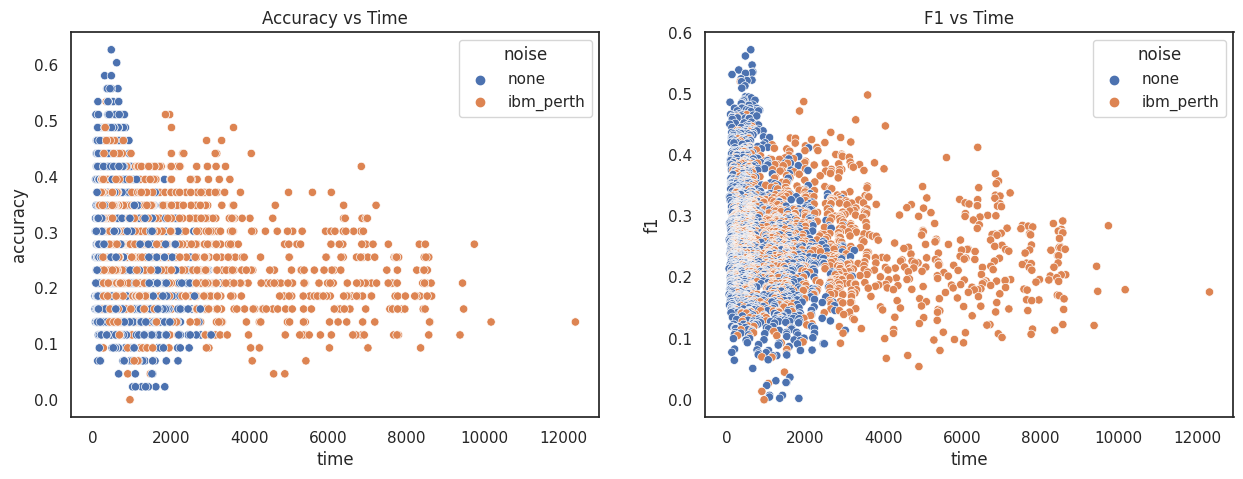

In [184]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=res, x='time', y='accuracy', hue='noise', ax=ax[0])
sns.scatterplot(data=res, x='time', y='f1', hue='noise', ax=ax[1])
ax[0].set_title('Accuracy vs Time')
ax[1].set_title('F1 vs Time')
plt.show()

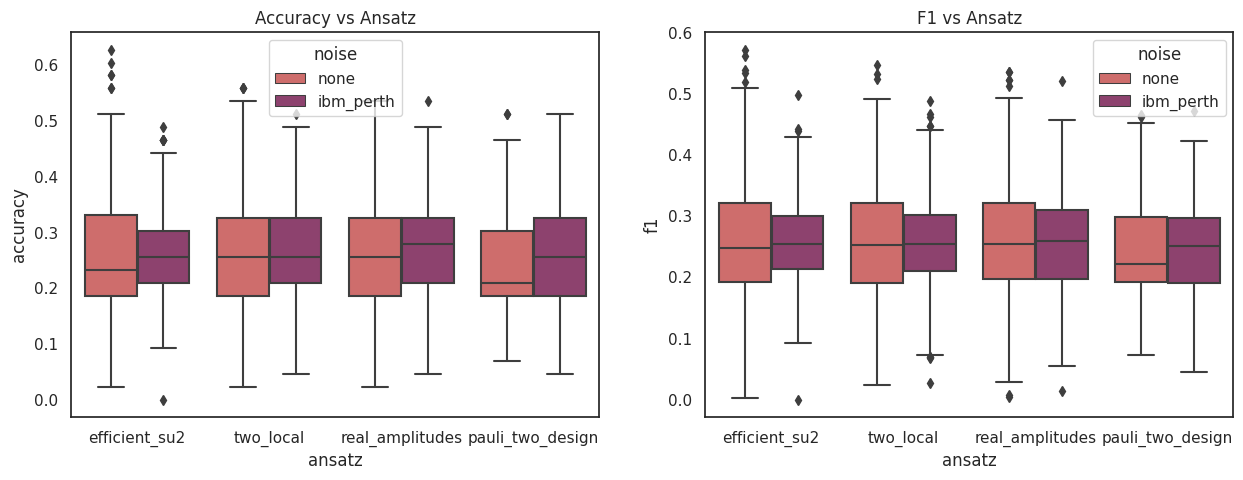

In [185]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=res, x='ansatz', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=res, x='ansatz', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Ansatz')
ax[1].set_title('F1 vs Ansatz')
plt.show()

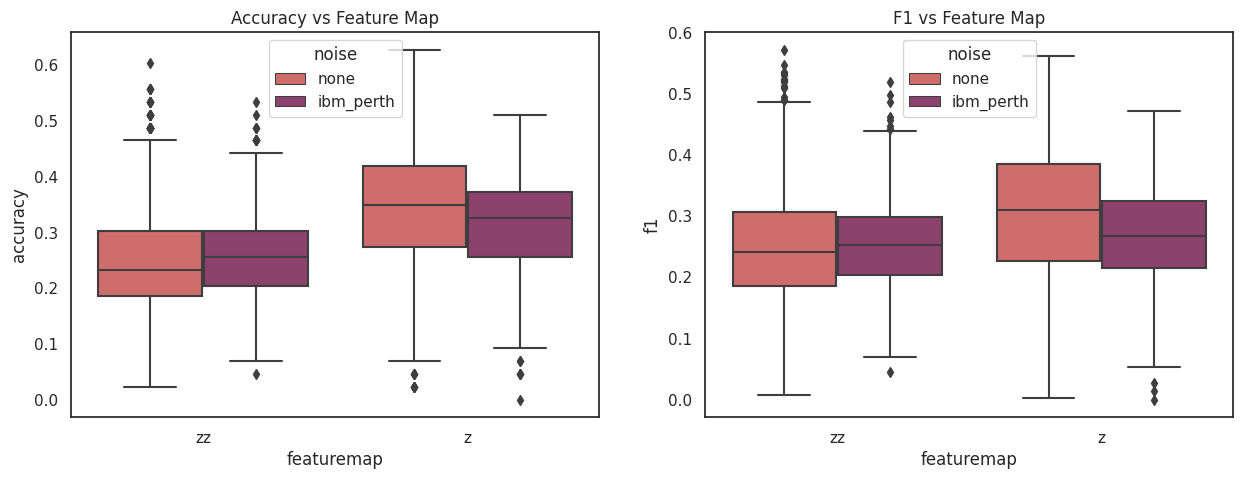

In [186]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=res, x='featuremap', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=res, x='featuremap', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Feature Map')
ax[1].set_title('F1 vs Feature Map')
plt.show()

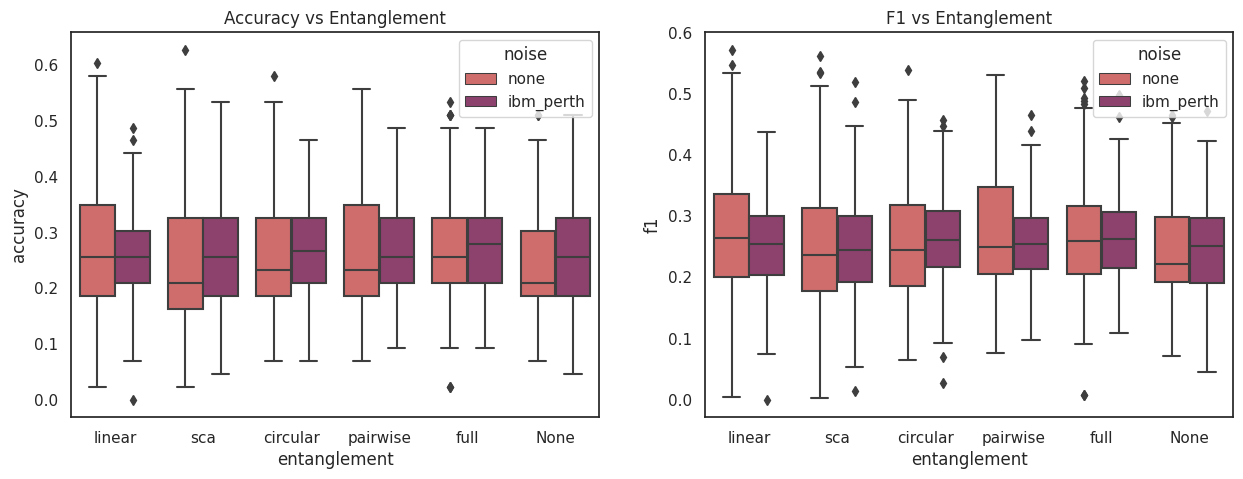

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
r = res.copy()
r.loc[r['entanglement'].isna(), 'entanglement'] = 'None'
sns.boxplot(data=r, x='entanglement', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=r, x='entanglement', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Entanglement')
ax[1].set_title('F1 vs Entanglement')
plt.show()

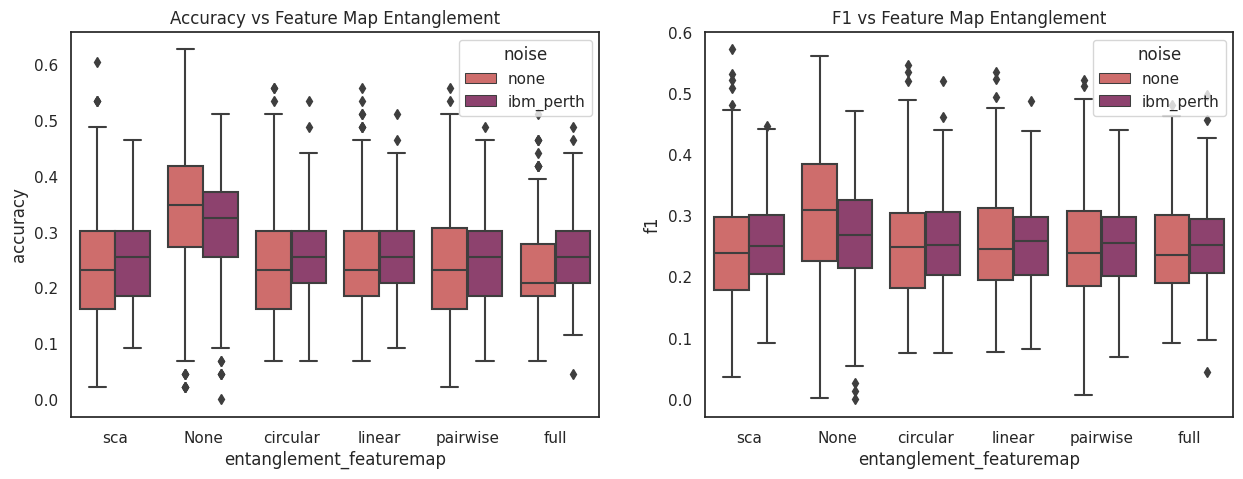

In [188]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
r = res.copy()
r.loc[r['entanglement_featuremap'].isna(), 'entanglement_featuremap'] = 'None'
sns.boxplot(data=r, x='entanglement_featuremap', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=r, x='entanglement_featuremap', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Feature Map Entanglement')
ax[1].set_title('F1 vs Feature Map Entanglement')
plt.show()


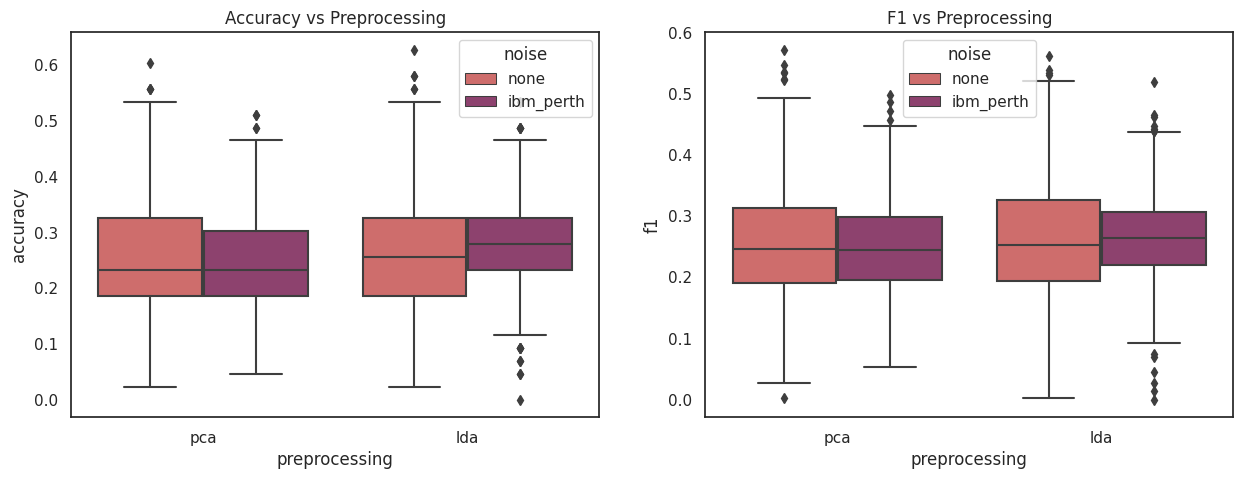

In [189]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=res, x='preprocessing', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=res, x='preprocessing', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Preprocessing')
ax[1].set_title('F1 vs Preprocessing')
plt.show()

## Analyze Differences

In [190]:
diff.name = 'difference'
d = diff.reset_index()

In [191]:
diff

ansatz         featuremap  entanglement  entanglement_featuremap  preprocessing  optimizer    initialization
efficient_su2  z           circular      NaN                      lda            cobyla       beta              0.186047
                                                                                              normal            0.093023
                                                                                              uniform           0.023256
                                                                                 nelder_mead  beta              0.023256
                                                                                              normal            0.093023
                                                                                                                  ...   
two_local      zz          sca           sca                      pca            nelder_mead  normal            0.093023
                                            

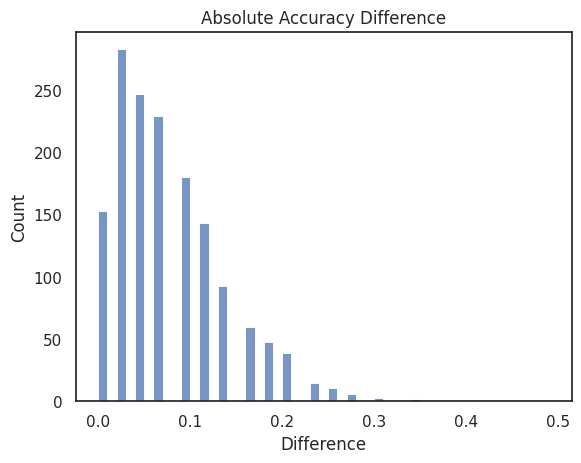

In [192]:
sns.histplot(d['difference'],bins=np.arange(0, 0.5, 0.01))
plt.title('Absolute Accuracy Difference')
plt.xlabel('Difference')
plt.ylabel('Count')
# plt.savefig("../reports/figures/covtype_absolute_differences.png", bbox_inches='tight')
plt.show()

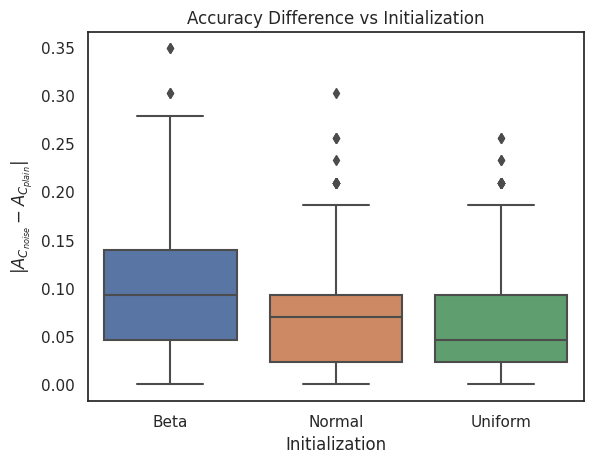

In [193]:
sns.boxplot(data=d, x='initialization', y='difference', palette='deep', order=['beta', 'normal', 'uniform'])
plt.xlabel("Initialization")
plt.xticks([0, 1, 2], ['Beta', 'Normal', 'Uniform'])
plt.ylabel("$|A_{C_{noise}} - A_{C_{plain}}|$")
plt.title("Accuracy Difference vs Initialization")
plt.savefig("../reports/figures/glass_absolute_differences_initialization.png", bbox_inches='tight')
plt.show()

## Plot

In [194]:
d = diff.reset_index()
d

,ansatz,featuremap,entanglement,entanglement_featuremap,preprocessing,optimizer,initialization,difference
0,efficient_su2,z,circular,NaN,lda,cobyla,beta,0.186047
1,efficient_su2,z,circular,NaN,lda,cobyla,normal,0.093023
2,efficient_su2,z,circular,NaN,lda,cobyla,uniform,0.023256
3,efficient_su2,z,circular,NaN,lda,nelder_mead,beta,0.023256
4,efficient_su2,z,circular,NaN,lda,nelder_mead,normal,0.093023
...,...,...,...,...,...,...,...,...
1507,two_local,zz,sca,sca,pca,nelder_mead,normal,0.093023
1508,two_local,zz,sca,sca,pca,nelder_mead,uniform,0.023256
1509,two_local,zz,sca,sca,pca,spsa,beta,0.000000
1510,two_local,zz,sca,sca,pca,spsa,normal,0.093023


In [195]:
diff.groupby(['initialization']).mean()

initialization
beta       0.093992
normal     0.069537
uniform    0.068291
Name: difference, dtype: float64